<a href="https://colab.research.google.com/github/ziatdinovmax/ActiveChannelLearning/blob/main/EnsembleDKL_channels_PFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Active Channel Learning with Ensembles of Deep Kernel Learning Models

*Notebook prepared by Maxim Ziatdinov (March 2022)*

- BEPFM and BEPS data acquired by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)
- Analyses of BE- data by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) (Funding: EFRC Award Number DE-SC0021118)
- PTO sample from [Hiroshi Funakubo](https://scholar.google.co.jp/citations?user=12EJj9gAAAAJ&hl=ja)


In this notebook, we show how to learn the channel with best predictive capability in DKL-based active learning.

## **Import and Download data**

In [ ]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax@v0.0.3
!pip install -U gdown

     |████████████████████████████████| 283 kB 4.4 MB/s 
     |████████████████████████████████| 309 kB 63.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=09a3e10745bdd21ed48b1b43c172b84fffb28249433f4928ae5d1297ff4d0dad
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [ ]:
from warnings import filterwarnings

import numpy as np
import matplotlib.pyplot as plt

import gpax

import numpyro
import haiku as hk
import jax
import jax.numpy as jnp

from sklearn.model_selection import train_test_split

gpax.utils.enable_x64()

In [ ]:
#@title Load helper functions  🛠️ { form-width: "20%" }
from typing import Tuple

def make_window(imgsrc: np.ndarray, window_size: int,
                xpos: int, ypos: int) -> np.ndarray:
    """
    Returns the portion of the image within the window given the
    image (imgsrc), the x position and the y position
    """
    imgsrc = imgsrc[int(xpos-window_size/2):int(xpos+window_size/2),
                    int(ypos-window_size/2):int(ypos+window_size/2)]
    return imgsrc


def create_training_set(imgdata: np.ndarray, target: np.ndarray,
                        window_size: int) -> Tuple[np.ndarray]:
    """
    Creates arrays with features (local subimages)
    and targets (corresponding spectra) from hyperspectral data
    """
    feature_arr, target_arr = [], []
    pos = []
    s1, s2 = imgdata.shape[:-1]
    for i in range(s1):
        for j in range(s2):
            arr_loc = make_window(imgdata, window_size, i, j)
            if arr_loc.shape[:-1] != (window_size, window_size):
                continue
            feature_arr.append(arr_loc)
            target_arr.append(target[i, j])
            pos.append([i, j])
    return np.array(pos), np.array(feature_arr), np.array(target_arr)

In [ ]:
!gdown https://drive.google.com/uc?id=1VdvoTJ1OaDo-qEIdgZJ1030aK5mBFcQh

Downloading...
From: https://drive.google.com/uc?id=1VdvoTJ1OaDo-qEIdgZJ1030aK5mBFcQh
To: /content/PTO_BEPS_3um.npz
100% 62.1M/62.1M [00:01<00:00, 31.6MB/s]


In [ ]:
BEPS = np.load("PTO_BEPS_3um.npz")
BEPS.files

['Image_Amplitude',
 'Image_Phase',
 'Image_Frequency',
 'Image_Q_Factor',
 'Image_Off_Field_Loop_Area',
 'Image_On_Field_Loop_Area',
 'Image_Loop_Width',
 'Image_Average_Coercive_Field',
 'Image_Negative_Coercive_Field',
 'Image_Positive_Coercive_Field',
 'Spectra_DC_Voltage',
 'Spectra_Off_Field_Loop',
 'Spectra_On_Field_Loop',
 'Spectra_On_Field_Frequency_Loop',
 'Spectra_Off_Field_Frequency_Loop']

We are going to work with the amplitude, phase, frequency, and Q-factor channels:

(100, 100, 4) (100, 100)


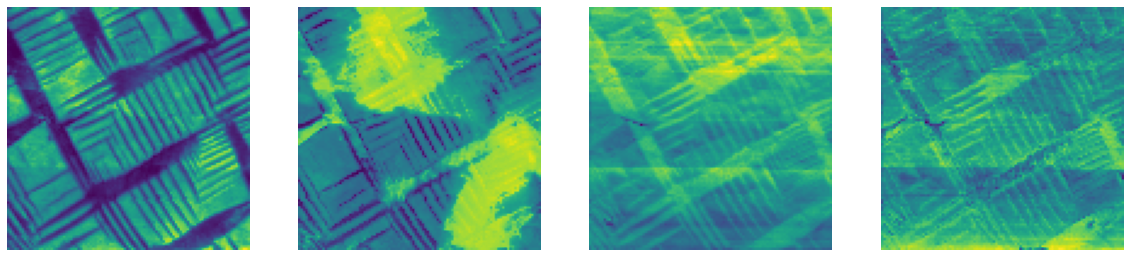

In [ ]:
# DKL inputs
amplitude = BEPS['Image_Amplitude'].astype(np.float64)
phase = BEPS["Image_Phase"].astype(np.float64)
frequency = BEPS["Image_Frequency"].astype(np.float64)
qfactor = BEPS["Image_Q_Factor"].astype(np.float64)
# DKL targets
loop_area = BEPS['Image_Off_Field_Loop_Area']

norm_ = lambda x: (x - x.min()) / x.ptp()

# Concatenate input channels
all_channels = np.concatenate(
    [
     norm_(amplitude)[..., None],
     norm_(phase)[..., None],
     norm_(frequency)[..., None],
     norm_(qfactor)[..., None]
     ], 
     axis=-1)
print(all_channels.shape, loop_area.shape)

# Plot
_, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(all_channels[..., i], origin='lower')
    ax.axis('off')

Create training data (patches with amplitude/phase/frequency/q-factor data as inputs and loop areas as target):

In [ ]:
indices_all, features_all, targets_all = create_training_set(all_channels, loop_area, 12)

#targets_all -= targets_all.mean()
#targets_all /= targets_all.std()

targets_all -= targets_all.min()
targets_all /= targets_all.ptp()

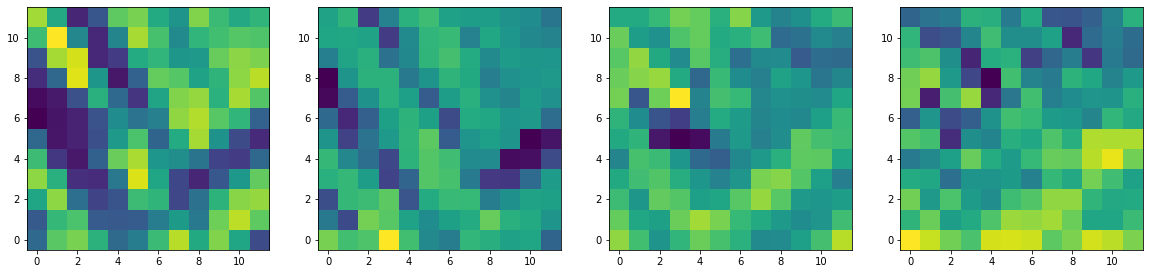

In [ ]:
k = 450

_, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axes):
    ax.imshow(features_all[k ,..., i], origin='lower',)
    ax.imshow(features_all[k ,..., i], origin='lower')

Define helper functions for active channel learning.

In [ ]:
class MLP2(hk.Module):
    """Simple custom MLP"""
    def __init__(self, embedim=2):
        super().__init__()
        self._embedim = embedim

    def __call__(self, x):
        x = hk.Linear(64)(x)
        x = jax.nn.tanh(x)
        x = hk.Linear(32)(x)
        x = jax.nn.tanh(x)
        x = hk.Linear(self._embedim)(x)
        return x


def step(X_train, y_train, X_unmeasured):
    """Single Ensemble-DKL step"""
    key, _ = gpax.utils.get_keys() 
    dkl = gpax.viDKL(X_train.shape[-1], z_dim=2, kernel='RBF', nn=MLP2)
    y_pred, covar_d = dkl.fit_predict(
        key, X_train, y_train, X_unmeasured,
        n_models=20, num_steps=2500, step_size=0.001)
    return y_pred.mean(0), covar_d.mean(0)


def get_best_channel(record):
    return record[:,1].argmax()


def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record


def get_reward(obj_history, obj):
    """A reward of +/-1 is given if the integral uncertainty at the current step
    is smaller/larger than the integral uncertainty at the previous step"""
    if jnp.nansum(obj) < obj_history[-1]:
        r = 1
    else:
        r = -1
    return r


def update_datapoints(next_point_idx, train, test):
    X_train, y_train, indices_train = train
    X_test, y_test, indices_test = test
    X_train = jnp.append(X_train, X_test[:, next_point_idx:next_point_idx+1], axis=1)
    X_test = jnp.delete(X_test, next_point_idx, axis=1)
    y_train = jnp.append(y_train, y_test[:, next_point_idx:next_point_idx+1], axis=-1)
    y_test = jnp.delete(y_test, next_point_idx, axis=-1)
    indices_train = jnp.append(indices_train, indices_test[next_point_idx:next_point_idx+1], axis=0)
    indices_test = jnp.delete(indices_test, next_point_idx, axis=0)
    return (X_train, y_train, indices_train), (X_test, y_test, indices_test)

Create training and 'unmeasured' dataset. We start with having only 1% of the grid points 'measured'.

In [ ]:
n, h, w, c = features_all.shape
features_all = features_all.reshape(n, h*w, c)

(X_train, X_unmeasured, y_train, y_unmeasured,
 indices_train, indices_unmeasured) = train_test_split(
    features_all, targets_all, indices_all, test_size=0.99, random_state=1)

X_train = X_train.transpose(2, 0, 1)
X_unmeasured = X_unmeasured.transpose(2, 0, 1)
y_train = y_train[None].repeat(X_train.shape[0], axis=0)
y_unmeasured = y_unmeasured[None].repeat(X_train.shape[0], axis=0)

X_train.shape, X_unmeasured.shape, y_train.shape, y_unmeasured.shape

((4, 79, 144), (4, 7842, 144), (4, 79), (4, 7842))

Run the active channel learning:

Warmup step 1/5


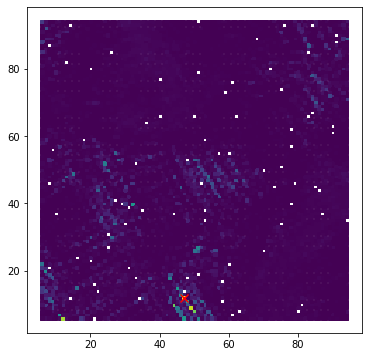

Warmup step 2/5


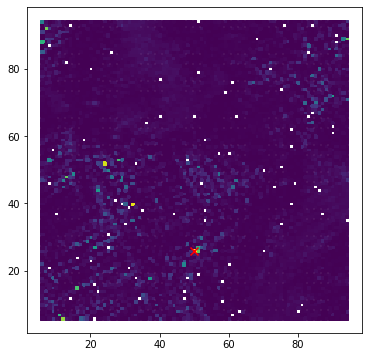

Warmup step 3/5


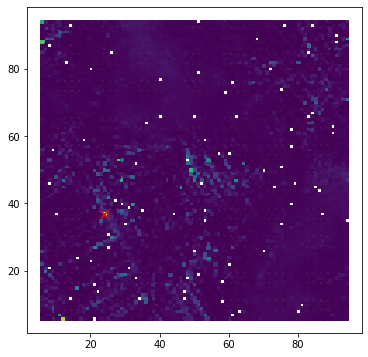

Warmup step 4/5


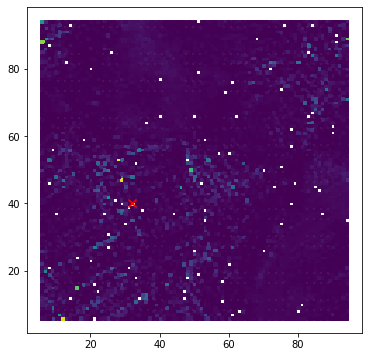

Warmup step 5/5


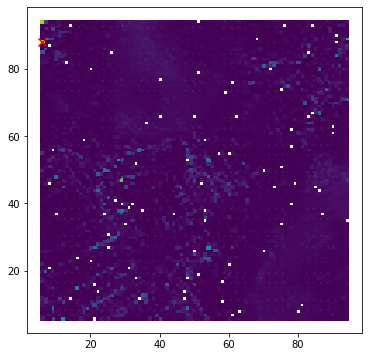


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 5  reward (avg) 1.0
channel 3:  counts 5  reward (avg) 0.0
channel 4:  counts 5  reward (avg) 0.0

Exploration step 1/30
Using channel 4


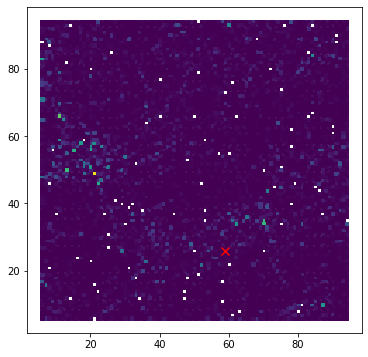


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 5  reward (avg) 1.0
channel 3:  counts 5  reward (avg) 0.0
channel 4:  counts 6  reward (avg) -0.167

Exploration step 2/30
Using channel 2


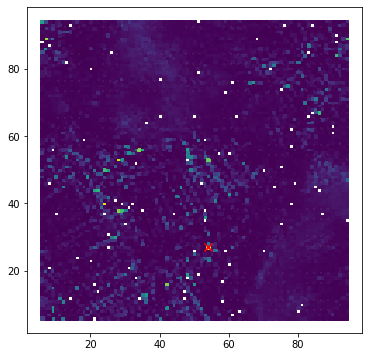


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 6  reward (avg) 1.0
channel 3:  counts 5  reward (avg) 0.0
channel 4:  counts 6  reward (avg) -0.167

Exploration step 3/30
Using channel 2


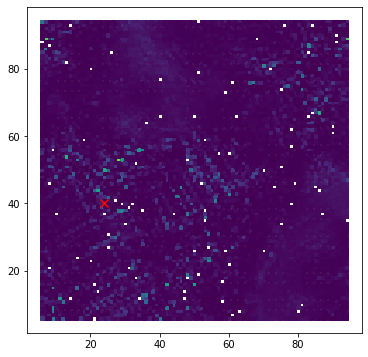


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 7  reward (avg) 1.0
channel 3:  counts 5  reward (avg) 0.0
channel 4:  counts 6  reward (avg) -0.167

Exploration step 4/30
Using channel 2


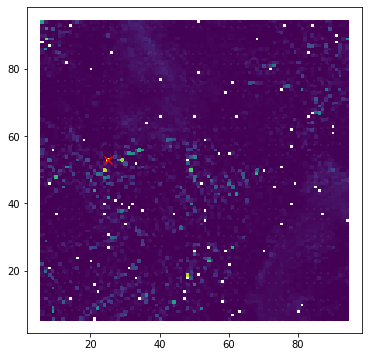


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 8  reward (avg) 1.0
channel 3:  counts 5  reward (avg) 0.0
channel 4:  counts 6  reward (avg) -0.167

Exploration step 5/30
Using channel 3


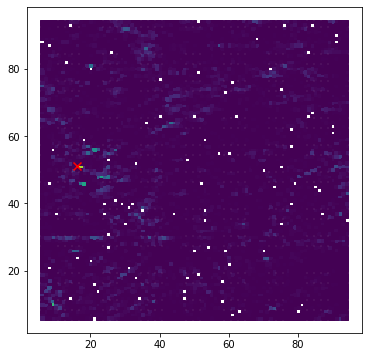


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 8  reward (avg) 1.0
channel 3:  counts 6  reward (avg) -0.167
channel 4:  counts 6  reward (avg) -0.167

Exploration step 6/30
Using channel 3


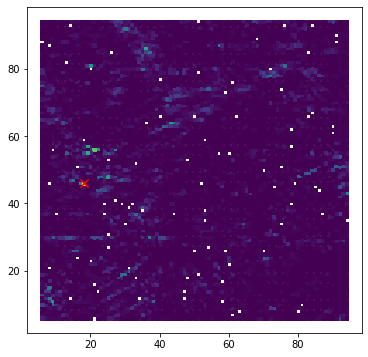


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 8  reward (avg) 1.0
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 7/30
Using channel 2


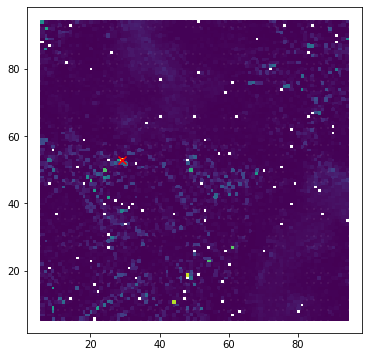


Rewards:
channel 1:  counts 5  reward (avg) 0.0
channel 2:  counts 9  reward (avg) 1.0
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 8/30
Using channel 1


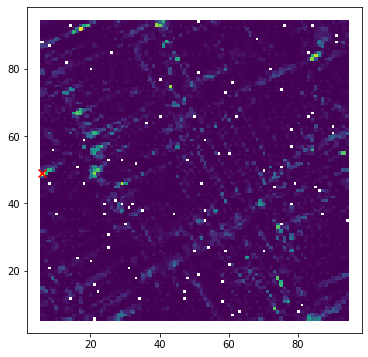


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 9  reward (avg) 1.0
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 9/30
Using channel 2


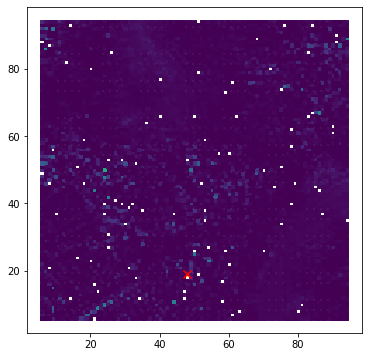


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 10  reward (avg) 1.0
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 10/30
Using channel 2


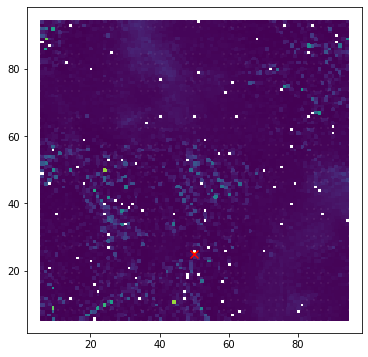


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 11  reward (avg) 0.818
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 6  reward (avg) -0.167

Exploration step 11/30
Using channel 4


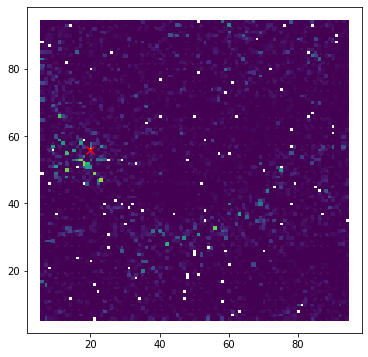


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 11  reward (avg) 0.818
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 12/30
Using channel 2


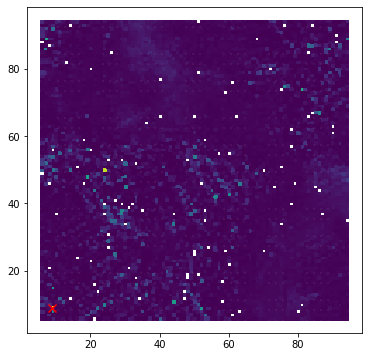


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 12  reward (avg) 0.833
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 13/30
Using channel 2


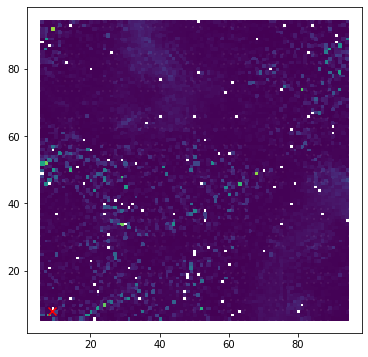


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 13  reward (avg) 0.846
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 14/30
Using channel 2


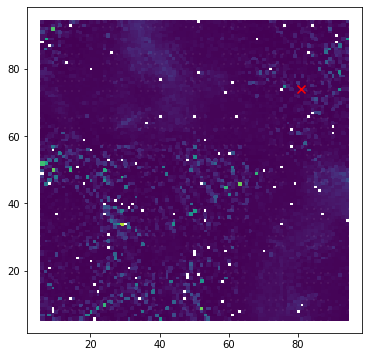


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 14  reward (avg) 0.714
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 15/30
Using channel 2


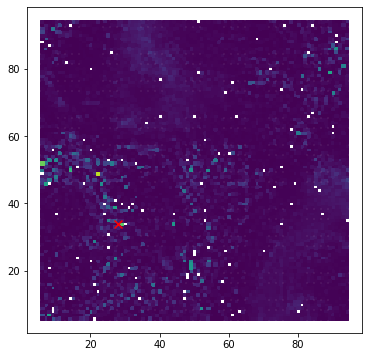


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 15  reward (avg) 0.6
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 16/30
Using channel 2


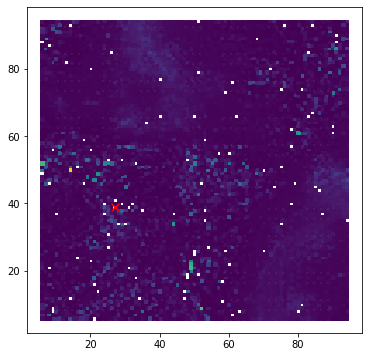


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 16  reward (avg) 0.5
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 17/30
Using channel 2


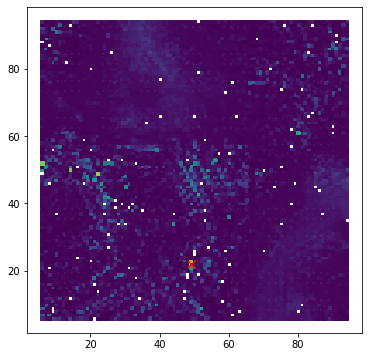


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 17  reward (avg) 0.529
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 18/30
Using channel 2


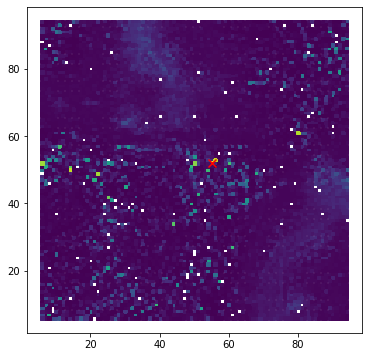


Rewards:
channel 1:  counts 6  reward (avg) -0.167
channel 2:  counts 18  reward (avg) 0.556
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 19/30
Using channel 1


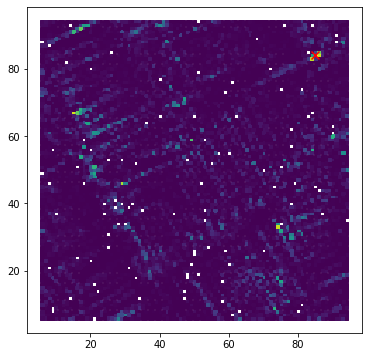


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 18  reward (avg) 0.556
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 20/30
Using channel 2


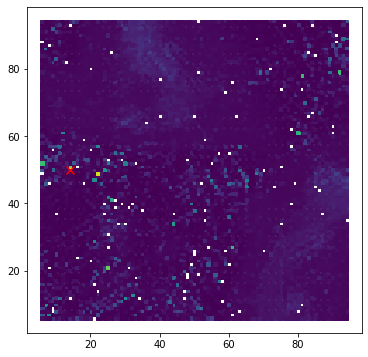


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 19  reward (avg) 0.474
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 21/30
Using channel 2


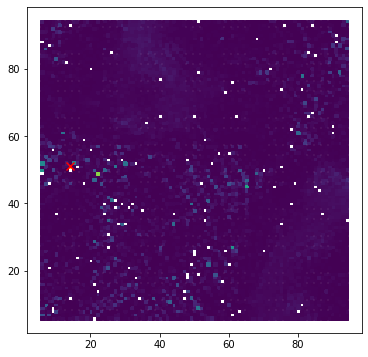


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 20  reward (avg) 0.5
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 22/30
Using channel 2


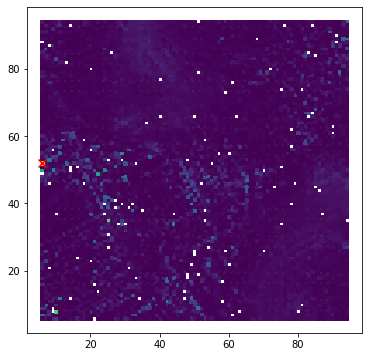


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 21  reward (avg) 0.429
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 23/30
Using channel 2


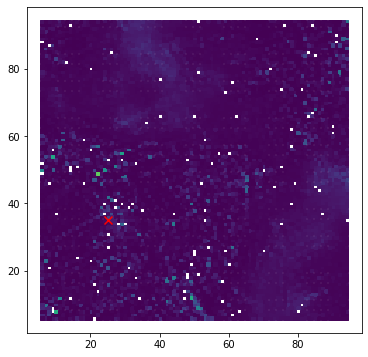


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 22  reward (avg) 0.364
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 24/30
Using channel 2


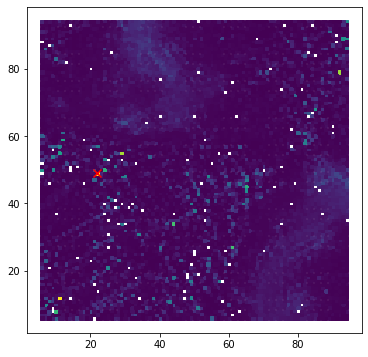


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 23  reward (avg) 0.391
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 25/30
Using channel 2


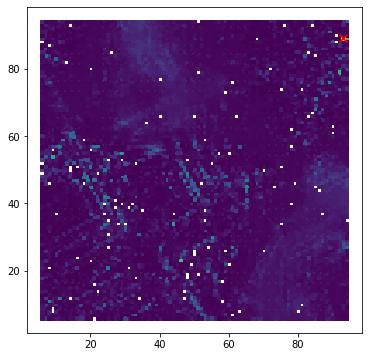


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 24  reward (avg) 0.333
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 26/30
Using channel 2


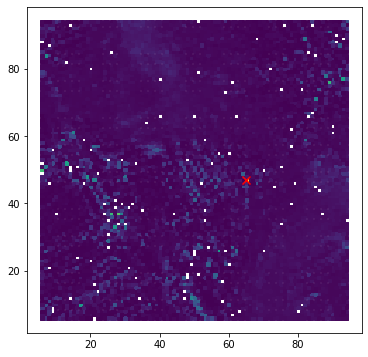


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 25  reward (avg) 0.28
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 27/30
Using channel 2


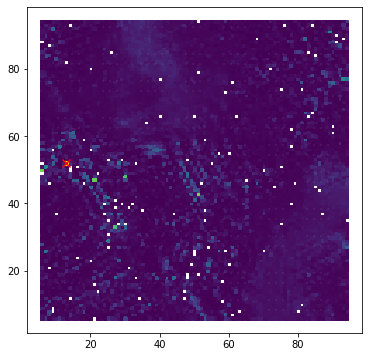


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 26  reward (avg) 0.308
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 28/30
Using channel 2


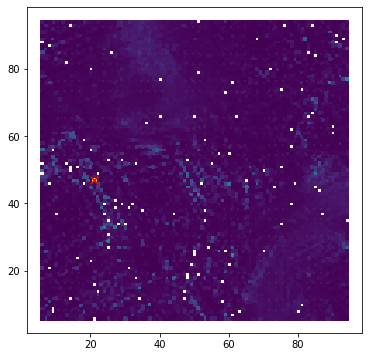


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 27  reward (avg) 0.333
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 29/30
Using channel 2


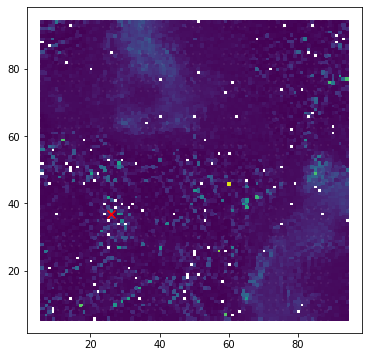


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 28  reward (avg) 0.286
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286

Exploration step 30/30
Using channel 2


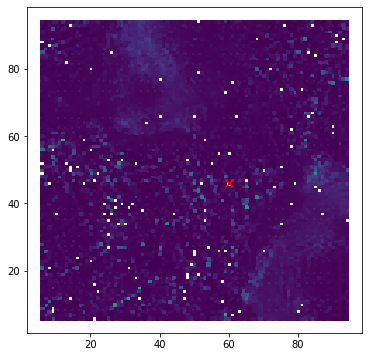


Rewards:
channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 29  reward (avg) 0.31
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286


In [ ]:
warmup_steps = 5
exploration_steps = 30
# epsilon in epsilon-greedy policy
#eps = np.ones(exploration_steps) * 0.4  # constant
eps = np.linspace(0.4, 0.1, exploration_steps)  # annealing

np.random.seed(55)  # rng seed for epsilon-greedy sampling
record = np.zeros((X_train.shape[0], 2))
channel_choices = []
var_history = []


def plot_acq():
    p = indices_unmeasured[next_point_idx]
    plt.figure(figsize=(6, 6))
    plt.scatter(indices_unmeasured[:, 1], indices_unmeasured[:, 0], c=obj, s=10, marker='s')
    plt.scatter(p[1], p[0], marker='x', s=64, c='red')
    plt.show()

# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    # Get/update DKL posteriors
    mean, var = step(X_train, y_train, X_unmeasured)
    record[:, 0] += 1
    # Select channel that resulted in lowest predictive uncertainty
    var_reduced = np.nansum(var, axis=-1)
    idx = np.argmin(var_reduced)
    # Update records
    var_history.append(var_reduced[idx].item())
    channel_choices.append(idx)
    record[idx, 1] += 1
    # get the next measurement point
    # obj = mean[idx] + 0.5 * jnp.sqrt(var[idx])  - UCB acqusition function
    obj = var[idx]
    next_point_idx = obj.argmax()
    plot_acq()
    # Do "measurement"
    measured_point = y_unmeasured[:, next_point_idx]
    # update datapoints
    (X_train, y_train, indices_train), (X_unmeasured, y_unmeasured, indices_unmeasured) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_unmeasured, y_unmeasured, indices_unmeasured)
    )

# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

# Print the running rewards
print("\nRewards:")
for i, r in enumerate(record):
    print("channel {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

# Exploration-exploitation phase
for e in range(exploration_steps):
    print("\nExploration step {}/{}".format(e+1, exploration_steps))
    # Choose channel according to epsilon-greedy policy
    eps_i = eps[e] if e < exploration_steps else eps[-1]
    if np.random.random() > eps_i: 
        idx = get_best_channel(record)
    else:
        idx = np.random.randint(record.shape[0])
    channel_choices.append(idx)
    print("Using channel {}".format(idx+1))
    # Update DKL posterior using the sampled channel
    mean, var = step(X_train[idx], y_train[idx], X_unmeasured[idx])
    # Get reward
    r = get_reward(var_history, var)
    # Update records
    record = update_record(record, idx, r)
    var_history.append(jnp.nansum(var).item())
    # Get the next measurement point
    # obj = mean + 0.5 * jnp.sqrt(var) - UCB acqusition function
    obj = var
    next_point_idx = obj.argmax()
    plot_acq()
    measured_point = y_unmeasured[:, next_point_idx]
    # update datapoints
    (X_train, y_train, indices_train), (X_unmeasured, y_unmeasured, indices_unmeasured) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_unmeasured, y_unmeasured, indices_unmeasured)
    )
    # Print the running rewards
    print("\nRewards:")
    for i, r in enumerate(record):
        print("channel {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

    # Store current points
    np.savez("ensembleDKL_channels_polar_norm01.npz",
         X_train=X_train, y_train=y_train, X_unmeasured=X_unmeasured,
         y_unmeasured=y_unmeasured, indices_unmeasured=indices_unmeasured,
         indices_measured=indices_train, record=record, channels_id=channel_choices,
         var_history=var_history)

View the results:

In [ ]:
for i, r in enumerate(record):
    print("channel {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), np.round(r[1], 3)))

channel 1:  counts 7  reward (avg) 0.0
channel 2:  counts 29  reward (avg) 0.31
channel 3:  counts 7  reward (avg) -0.286
channel 4:  counts 7  reward (avg) -0.286


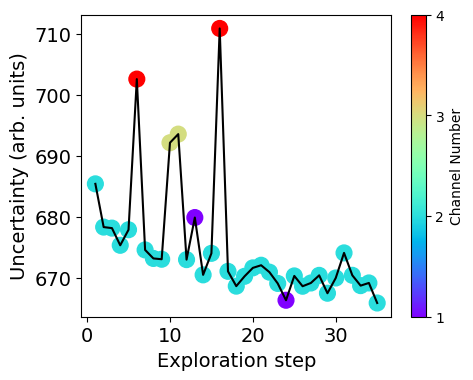

In [ ]:
plt.figure(figsize = (5, 4), dpi=100)
plt.plot(np.arange(1, exploration_steps+warmup_steps+1), var_history, c='k')
plt.scatter(np.arange(1, exploration_steps+warmup_steps+1), var_history,
            c=[m+1 for m in channel_choices],
            s=128, cmap='rainbow', alpha=1)
plt.xlabel("Exploration step", fontsize=14)
plt.ylabel("Uncertainty (arb. units)", fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
cbar = plt.colorbar(label = "Channel Number")
cbar.set_ticks([1, 2, 3, 4])

Run DKL for all the channels and plot prediction:

In [ ]:
mean, var = step(X_train, y_train, X_unmeasured)

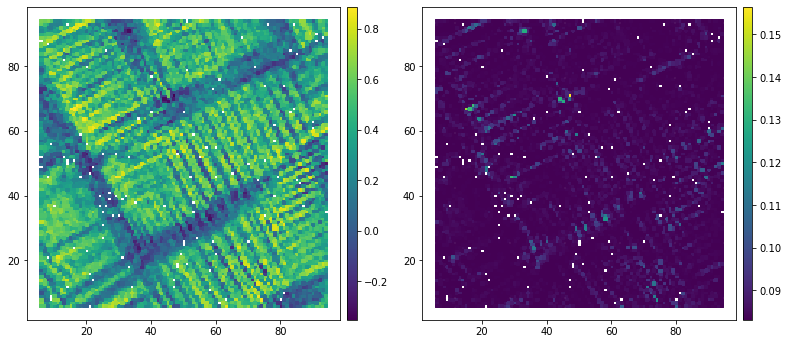

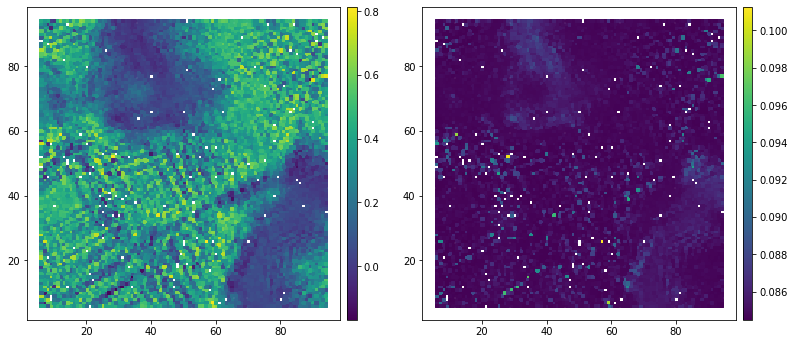

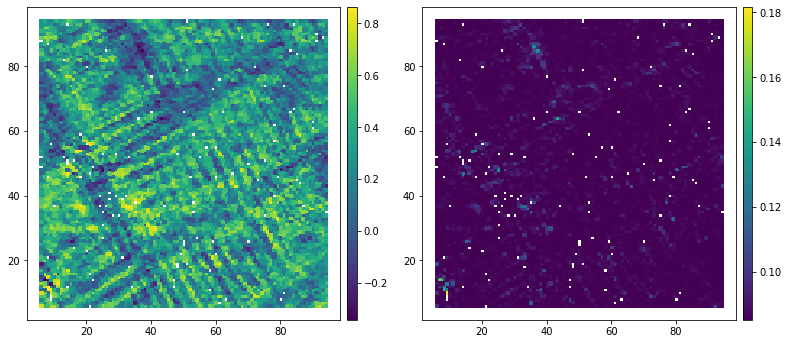

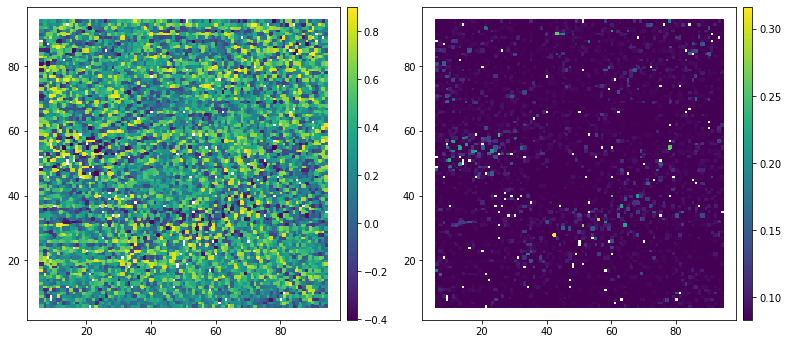

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for m, v in zip(mean, var):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    im1 = ax1.scatter(indices_unmeasured[:, 1], indices_unmeasured[:, 0], c=m, s=10, marker='s')
    ax1.set_aspect('equal')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    im2 = ax2.scatter(indices_unmeasured[:, 1], indices_unmeasured[:, 0], c=v, s=10, marker='s')
    ax2.set_aspect('equal')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im2, cax=cax, orientation='vertical')
    plt.show()

Error in prediction for all channels:

In [ ]:
print(jnp.sum((abs(mean - y_unmeasured)), axis=-1))

[1441.76315171 1218.18390502 1587.79979187 2312.91455223]
